In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch
# from GEH_LOSS import GEH_loss
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import relative_accuracy as ra

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
# Wide Data
Xtrain = joblib.load("002weeks_train_Multi.save") 
Xtest = joblib.load("002weeks_test_Multi.save") 

In [7]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [8]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [9]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [10]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [11]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [12]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [13]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
# val_percent = 0.07567       # 2 weeks
val_percent = 0.2        
batch_size = 32

n_seq_ = 3                     # Subsequences
n_steps_ = 3                   # time-step per subsequence

#### 5 mins

In [14]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [15]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [16]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [17]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [18]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [19]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [20]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [21]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [22]:
# define no_of_channels
n_channels = 1

In [23]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [24]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

In [25]:
# Train data
Wt5  =  Wt5.reshape(Wt5.shape[0], n_seq_, n_steps_, n_features)
Wt15 =  Wt15.reshape(Wt15.shape[0], n_seq_, n_steps_, n_features)
Wt30 =  Wt30.reshape(Wt30.shape[0], n_seq_, n_steps_, n_features)
Wt60 =  Wt60.reshape(Wt60.shape[0], n_seq_, n_steps_, n_features)

# Validation data
Wv5  =  Wv5.reshape(Wv5.shape[0], n_seq_, n_steps_, n_features)
Wv15 =  Wv15.reshape(Wv15.shape[0], n_seq_, n_steps_, n_features)
Wv30 =  Wv30.reshape(Wv30.shape[0], n_seq_, n_steps_, n_features)
Wv60 =  Wv60.reshape(Wv60.shape[0], n_seq_, n_steps_, n_features)

In [26]:
Xt5.shape

(49233, 3, 5, 6, 1)

In [27]:
Wt5.shape

(49233, 3, 3, 6)

# CNN-LSTM model

In [28]:
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)

In [29]:
Wide_train_5.shape

(49233, 9, 6)

# 5 mins ahead

In [30]:
def build_model_5(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt5.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt5.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_5w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_5 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_5w)
    
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=units, return_sequences=True)(flatten_5)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_5, LSTM_5], axis=1)

    # Attention
    Att_5 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_5)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss="mae", metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                                   
    return model_5

In [31]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8b-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8b-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8b-5\tuner0.json


In [32]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [33]:
tuner5.search((Wt5,Xt5), yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 61 Complete [00h 05m 04s]
val_loss: 18.150599479675293

Best val_loss So Far: 13.497985363006592
Total elapsed time: 01h 31m 37s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\8b-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 88
filters: 160
kernel_size: 2
learning_rate: 0.001
Score: 13.497985363006592


### Best Model

In [35]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [36]:
scaler_filename = "Best_HP/8b-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/8b-5']

In [37]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 160  800        ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [38]:
model5.fit((Wt5,Xt5), yt5, 
           epochs = 100, 
           verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 20s 11ms/step - loss: 39.9376 - mean_absolute_error: 39.9376 - root_mean_squared_error: 68.0062 - mean_absolute_percentage_error: 44.4628
Epoch 2/100
1539/1539 [==============================] - 16s 11ms/step - loss: 16.7257 - mean_absolute_error: 16.7257 - root_mean_squared_error: 24.5715 - mean_absolute_percentage_error: 25.4230
Epoch 3/100
1539/1539 [==============================] - 16s 11ms/step - loss: 15.5892 - mean_absolute_error: 15.5892 - root_mean_squared_error: 22.9250 - mean_absolute_percentage_error: 23.3485
Epoch 4/100
1539/1539 [==============================] - 17s 11ms/step - loss: 14.8193 - mean_absolute_error: 14.8193 - root_mean_squared_error: 21.4277 - mean_absolute_percentage_error: 21.2493
Epoch 5/100
1539/1539 [==============================] - 16s 11ms/step - loss: 14.3123 - mean_absolute_error: 14.3123 - root_mean_squared_error: 20.5964 - mean_absolute_percentage_error: 20.0922
Epoch 6/100
1539/1539 [==

1539/1539 [==============================] - 16s 11ms/step - loss: 10.6368 - mean_absolute_error: 10.6368 - root_mean_squared_error: 16.0705 - mean_absolute_percentage_error: 14.2885
Epoch 82/100
1539/1539 [==============================] - 17s 11ms/step - loss: 10.5881 - mean_absolute_error: 10.5881 - root_mean_squared_error: 16.0128 - mean_absolute_percentage_error: 14.2796
Epoch 83/100
1539/1539 [==============================] - 16s 11ms/step - loss: 10.5525 - mean_absolute_error: 10.5525 - root_mean_squared_error: 15.9660 - mean_absolute_percentage_error: 14.2274
Epoch 84/100
1539/1539 [==============================] - 16s 11ms/step - loss: 10.5067 - mean_absolute_error: 10.5067 - root_mean_squared_error: 15.9064 - mean_absolute_percentage_error: 14.2030
Epoch 85/100
1539/1539 [==============================] - 16s 11ms/step - loss: 10.4756 - mean_absolute_error: 10.4756 - root_mean_squared_error: 15.8571 - mean_absolute_percentage_error: 14.1760
Epoch 86/100
1539/1539 [=========

In [39]:
model5.save("my_dir/8b-5")

INFO:tensorflow:Assets written to: my_dir/8b-5\assets


INFO:tensorflow:Assets written to: my_dir/8b-5\assets


In [40]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

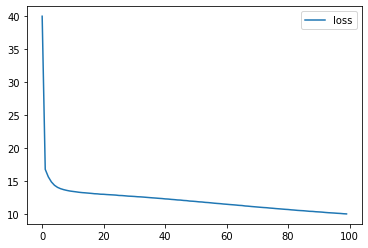

In [41]:
metrics5[['loss']].plot()

In [33]:
model5 = keras.models.load_model("my_dir/8b-5") 

In [34]:
model5.predict((Wv5,Xv5))

array([[ 29.449139 ,  17.443388 ,  24.427925 ,  72.8606   ,  29.999266 ,
          5.171674 ],
       [ 29.731272 ,  18.11526  ,  26.211586 ,  77.20301  ,  31.163206 ,
          6.198778 ],
       [ 29.235147 ,  17.553263 ,  22.993195 ,  71.809456 ,  27.462847 ,
          5.3308945],
       ...,
       [ 43.448788 ,  39.50941  ,  60.61557  , 106.984215 ,  50.810806 ,
         18.68334  ],
       [ 42.79888  ,  39.55882  ,  50.152847 ,  97.07196  ,  43.711212 ,
          8.825221 ],
       [ 42.71675  ,  42.6231   ,  57.070206 , 101.623215 ,  44.937283 ,
         11.293179 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions5 = model5.predict((Wv5,Xv5))


MSE5 = mean_squared_error(yv5,test_predictions5)

MAE5 = mean_absolute_error(yv5,test_predictions5)

RMSE5 = np.sqrt(MSE5)

MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

eval5 = [MSE5, MAE5, RMSE5, MAPE5]
print(eval5)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH5 = count/GEH.size
print(GEH5)

# 15 mins ahead

In [37]:
def build_model_15(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt15.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt15.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_15w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_15 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_15w)
    
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=units, return_sequences=True)(flatten_15)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_15, LSTM_15], axis=1)

    # Attention
    Att_15 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_15)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss="mae", metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [38]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8b-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8b-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8b-15\tuner0.json


In [39]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
tuner15.search((Wt15,Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 60 Complete [00h 15m 46s]
val_loss: 15.760492324829102

Best val_loss So Far: 14.443315505981445
Total elapsed time: 09h 12m 17s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [50]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\8b-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 99
filters: 256
kernel_size: 2
learning_rate: 0.001
Score: 14.443315505981445


### Best model

In [51]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [52]:
scaler_filename = "Best_HP/8b-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/8b-15']

In [53]:
model15.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 256  1280       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [54]:
model15.fit((Wt15,Xt15), yt15, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 50s 29ms/step - loss: 38.7354 - mean_absolute_error: 38.7354 - root_mean_squared_error: 65.6220 - mean_absolute_percentage_error: 45.7740
Epoch 2/100
1539/1539 [==============================] - 45s 29ms/step - loss: 17.6941 - mean_absolute_error: 17.6941 - root_mean_squared_error: 25.8648 - mean_absolute_percentage_error: 26.6499
Epoch 3/100
1539/1539 [==============================] - 45s 29ms/step - loss: 16.6055 - mean_absolute_error: 16.6055 - root_mean_squared_error: 24.3123 - mean_absolute_percentage_error: 24.3932
Epoch 4/100
1539/1539 [==============================] - 45s 29ms/step - loss: 15.9047 - mean_absolute_error: 15.9047 - root_mean_squared_error: 23.0029 - mean_absolute_percentage_error: 22.7868
Epoch 5/100
1539/1539 [==============================] - 45s 29ms/step - loss: 15.4521 - mean_absolute_error: 15.4521 - root_mean_squared_error: 22.2759 - mean_absolute_percentage_error: 21.5961
Epoch 6/100
1539/1539 [==

1539/1539 [==============================] - 45s 29ms/step - loss: 11.3266 - mean_absolute_error: 11.3266 - root_mean_squared_error: 17.3280 - mean_absolute_percentage_error: 15.0563
Epoch 84/100
1539/1539 [==============================] - 45s 29ms/step - loss: 11.2978 - mean_absolute_error: 11.2978 - root_mean_squared_error: 17.2736 - mean_absolute_percentage_error: 15.0187
Epoch 85/100
1539/1539 [==============================] - 45s 29ms/step - loss: 11.2605 - mean_absolute_error: 11.2605 - root_mean_squared_error: 17.2342 - mean_absolute_percentage_error: 14.9885
Epoch 86/100
1539/1539 [==============================] - 45s 29ms/step - loss: 11.2171 - mean_absolute_error: 11.2171 - root_mean_squared_error: 17.1727 - mean_absolute_percentage_error: 14.9357
Epoch 87/100
1539/1539 [==============================] - 45s 29ms/step - loss: 11.1919 - mean_absolute_error: 11.1919 - root_mean_squared_error: 17.1414 - mean_absolute_percentage_error: 14.8967
Epoch 88/100
1539/1539 [=========

In [55]:
model15.save("my_dir/8b-15")

INFO:tensorflow:Assets written to: my_dir/8b-15\assets


INFO:tensorflow:Assets written to: my_dir/8b-15\assets


In [56]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

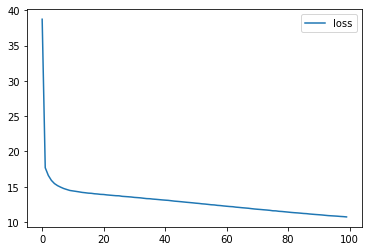

In [57]:
metrics15[['loss']].plot()

In [40]:
model15 = keras.models.load_model("my_dir/8b-15")

In [41]:
model15.predict((Wv15,Xv15))

array([[ 28.292416 ,  15.795567 ,  26.74224  ,  68.778786 ,  29.899263 ,
          4.5864697],
       [ 28.50002  ,  15.571213 ,  24.84205  ,  66.34828  ,  28.133608 ,
          5.3194304],
       [ 28.557968 ,  15.680347 ,  25.813517 ,  72.045975 ,  30.647814 ,
          4.919055 ],
       ...,
       [ 46.543087 ,  49.851227 ,  73.87767  , 125.43842  ,  58.934864 ,
         17.380802 ],
       [ 40.199986 ,  40.092133 ,  60.300114 , 115.34034  ,  53.539112 ,
         10.289107 ],
       [ 44.671463 ,  43.250412 ,  59.041004 , 114.65913  ,  55.77885  ,
         12.391005 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions15 = model15.predict((Wv15,Xv15))


MSE15 = mean_squared_error(yv15,test_predictions15)

MAE15 = mean_absolute_error(yv15,test_predictions15)

RMSE15 = np.sqrt(MSE15)

MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

eval15 = [MSE15, MAE15, RMSE15, MAPE15]
print(eval15)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))
GEH15 = count/GEH.size
print(GEH15)

# 30 mins ahead

In [44]:
def build_model_30(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt30.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt30.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_30w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_30 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_30w)
    
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=units, return_sequences=True)(flatten_30)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_30, LSTM_30], axis=1)

    # Attention
    Att_30 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_30)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss="mae", metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [45]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8b-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8b-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8b-30\tuner0.json


In [46]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [47]:
tuner30.search((Wt30,Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 61 Complete [00h 21m 57s]
val_loss: 18.207335472106934

Best val_loss So Far: 15.222926616668701
Total elapsed time: 04h 18m 36s
INFO:tensorflow:Oracle triggered exit


In [48]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\8b-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 89
filters: 352
kernel_size: 2
learning_rate: 0.001
Score: 15.222926616668701


### Best model

In [49]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [50]:
scaler_filename = "8b-30"
joblib.dump(best_hp30, scaler_filename) 

['8b-30']

In [51]:
model30.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 352  1760       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [52]:
model30.fit((Wt30,Xt30), yt30, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 44s 26ms/step - loss: 41.8275 - mean_absolute_error: 41.8275 - root_mean_squared_error: 69.1243 - mean_absolute_percentage_error: 48.7888
Epoch 2/100
1539/1539 [==============================] - 40s 26ms/step - loss: 19.2479 - mean_absolute_error: 19.2479 - root_mean_squared_error: 28.0910 - mean_absolute_percentage_error: 28.5514
Epoch 3/100
1539/1539 [==============================] - 40s 26ms/step - loss: 17.5856 - mean_absolute_error: 17.5856 - root_mean_squared_error: 25.7962 - mean_absolute_percentage_error: 26.2244
Epoch 4/100
1539/1539 [==============================] - 40s 26ms/step - loss: 17.1366 - mean_absolute_error: 17.1366 - root_mean_squared_error: 25.0399 - mean_absolute_percentage_error: 24.86095s - loss: 17.1645 - mean_absolute_error: 17.1645 - root_mean_squared_error: 25.0705 - m
Epoch 5/100
1539/1539 [==============================] - 40s 26ms/step - loss: 16.6376 - mean_absolute_error: 16.6376 - root_mean_sq

1539/1539 [==============================] - 40s 26ms/step - loss: 11.9626 - mean_absolute_error: 11.9626 - root_mean_squared_error: 18.2069 - mean_absolute_percentage_error: 15.9688
Epoch 84/100
1539/1539 [==============================] - 40s 26ms/step - loss: 11.9167 - mean_absolute_error: 11.9167 - root_mean_squared_error: 18.1487 - mean_absolute_percentage_error: 15.9234
Epoch 85/100
1539/1539 [==============================] - 40s 26ms/step - loss: 11.8800 - mean_absolute_error: 11.8800 - root_mean_squared_error: 18.1006 - mean_absolute_percentage_error: 15.8687
Epoch 86/100
1539/1539 [==============================] - 40s 26ms/step - loss: 11.8516 - mean_absolute_error: 11.8516 - root_mean_squared_error: 18.0425 - mean_absolute_percentage_error: 15.8614
Epoch 87/100
1539/1539 [==============================] - 40s 26ms/step - loss: 11.7990 - mean_absolute_error: 11.7990 - root_mean_squared_error: 17.9931 - mean_absolute_percentage_error: 15.8208
Epoch 88/100
1539/1539 [=========

In [53]:
model30.save("my_dir/8b-30")

INFO:tensorflow:Assets written to: my_dir/8b-30\assets


INFO:tensorflow:Assets written to: my_dir/8b-30\assets


In [54]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

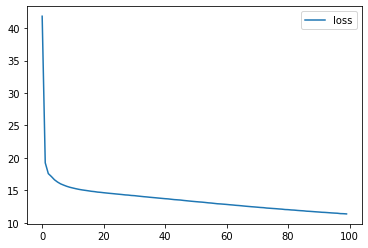

In [55]:
metrics30[['loss']].plot()

In [56]:
model30 = keras.models.load_model("my_dir/8b-30")

In [57]:
model30.predict((Wv30,Xv30))

array([[ 29.343122 ,  15.236221 ,  36.15454  ,  63.903374 ,  25.479877 ,
          5.0345173],
       [ 28.497854 ,  15.152637 ,  14.715818 ,  59.058044 ,  25.379156 ,
          5.422608 ],
       [ 28.549734 ,  14.1088295,  24.037624 ,  59.422997 ,  28.096994 ,
          5.3759975],
       ...,
       [ 41.757164 ,  36.316044 ,  66.49898  , 111.77511  ,  49.633015 ,
         13.991615 ],
       [ 42.368195 ,  39.8477   ,  67.027306 , 127.98414  ,  56.794773 ,
         14.663796 ],
       [ 40.596268 ,  32.985794 ,  46.323845 ,  95.835724 ,  36.62664  ,
          5.5883026]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions30 = model30.predict((Wv30,Xv30))


MSE30 = mean_squared_error(yv30,test_predictions30)

MAE30 = mean_absolute_error(yv30,test_predictions30)

RMSE30 = np.sqrt(MSE30)

MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

eval30 = [MSE30, MAE30, RMSE30, MAPE30]
print(eval30)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))
GEH30 = count/GEH.size
print(GEH30)

# 60 mins ahead

In [62]:
def build_model_60(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt60.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt60.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_60w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_60 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_60w)
    
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=units, return_sequences=True)(flatten_60)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_60, LSTM_60], axis=1)

    # Attention
    Att_60 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_60)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss="mae", metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [63]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8b-60",
)

In [64]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [65]:
tuner60.search((Wt60,Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 60 Complete [00h 13m 18s]
val_loss: 16.664888381958008

Best val_loss So Far: 16.058810234069824
Total elapsed time: 04h 57m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [66]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\8b-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 69
filters: 32
kernel_size: 2
learning_rate: 0.001
Score: 16.058810234069824


### Best model

In [67]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [68]:
scaler_filename = "Best_HP/8b-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/8b-60']

In [69]:
model60.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 32)  160        ['DeepInput[0][0]']              
 buted)                                                                                           
                                                                                            

In [70]:
model60.fit((Wt60,Xt60), yt60, 
            epochs = 100, 
            verbose = 1
            )

Epoch 1/100
1539/1539 [==============================] - 16s 8ms/step - loss: 46.5379 - mean_absolute_error: 46.5379 - root_mean_squared_error: 75.2322 - mean_absolute_percentage_error: 52.1948
Epoch 2/100
1539/1539 [==============================] - 12s 8ms/step - loss: 22.7269 - mean_absolute_error: 22.7269 - root_mean_squared_error: 32.9977 - mean_absolute_percentage_error: 31.9600
Epoch 3/100
1539/1539 [==============================] - 12s 8ms/step - loss: 18.8929 - mean_absolute_error: 18.8929 - root_mean_squared_error: 27.8134 - mean_absolute_percentage_error: 28.2514
Epoch 4/100
1539/1539 [==============================] - 12s 8ms/step - loss: 18.2892 - mean_absolute_error: 18.2892 - root_mean_squared_error: 27.0074 - mean_absolute_percentage_error: 26.7564 1s - loss: 18.3117 - mean_absolute_error: 18.3117 - root_mean_squared_error:
Epoch 5/100
1539/1539 [==============================] - 12s 8ms/step - loss: 17.9254 - mean_absolute_error: 17.9254 - root_mean_squared_error: 26.

1539/1539 [==============================] - 12s 8ms/step - loss: 14.2698 - mean_absolute_error: 14.2698 - root_mean_squared_error: 21.3162 - mean_absolute_percentage_error: 18.9066 0s - loss: 14.2670 - mean_absolute_error: 14.2670 - root_mean_squared_error: 21.3136 - mean_absolute
Epoch 83/100
1539/1539 [==============================] - 12s 8ms/step - loss: 14.2408 - mean_absolute_error: 14.2408 - root_mean_squared_error: 21.2678 - mean_absolute_percentage_error: 18.8748
Epoch 84/100
1539/1539 [==============================] - 12s 8ms/step - loss: 14.2281 - mean_absolute_error: 14.2281 - root_mean_squared_error: 21.2502 - mean_absolute_percentage_error: 18.8525
Epoch 85/100
1539/1539 [==============================] - 12s 8ms/step - loss: 14.2227 - mean_absolute_error: 14.2227 - root_mean_squared_error: 21.2491 - mean_absolute_percentage_error: 18.8441
Epoch 86/100
1539/1539 [==============================] - 12s 8ms/step - loss: 14.1865 - mean_absolute_error: 14.1865 - root_mean_sq

In [71]:
model60.save("my_dir/8b-60")

INFO:tensorflow:Assets written to: my_dir/8b-60\assets


INFO:tensorflow:Assets written to: my_dir/8b-60\assets


In [72]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

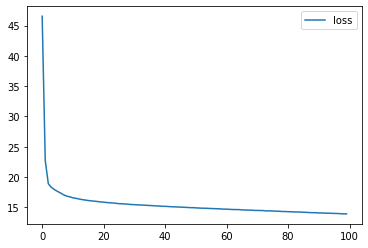

In [73]:
metrics60[['loss']].plot()

In [74]:
model60 = keras.models.load_model("my_dir/8b-60")

In [75]:
model60.predict((Wv60,Xv60))

array([[ 29.023537 ,  14.997673 ,  16.492004 ,  61.57861  ,  27.519388 ,
          5.985657 ],
       [ 28.31282  ,  13.842947 ,  12.773359 ,  59.460682 ,  28.419483 ,
          5.6061854],
       [ 29.35048  ,  15.124817 ,  13.284662 ,  59.66676  ,  28.277412 ,
          5.3574452],
       ...,
       [ 43.330647 ,  37.764244 ,  55.550213 , 114.64623  ,  43.710777 ,
          5.8330617],
       [ 42.942356 ,  38.4175   ,  57.47635  , 120.02935  ,  44.887753 ,
          4.1461067],
       [ 38.796383 ,  33.45255  ,  55.40633  , 109.43807  ,  42.90502  ,
          3.7495518]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions60 = model60.predict((Wv60,Xv60))


MSE60 = mean_squared_error(yv60,test_predictions60)

MAE60 = mean_absolute_error(yv60,test_predictions60)

RMSE60 = np.sqrt(MSE60)

MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

eval60 = [MSE60, MAE60, RMSE60, MAPE60]
print(eval60)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))
GEH60 = count/GEH.size
print(GEH60)